In [2]:
# Imports for EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

In [3]:
# Loading data w/ encoding fix

df = pd.read_csv('../data/raw/startups_data.csv', encoding='latin-1')

## Initial Early Data Overview

**Dataset Size**: 54,294 startups w/ 39 features

**Key Features Confirmed**
- **Geographic**: country_code, region, city
- **Industry**: category_list, market
- **Funding**: funding_total_usd, funding rounds (A-H), funding types
- **Temporal**: founded_year`, funding dates
- **Target**: status (acquired/operating/closed)

In [4]:
# Some brief early exploration - rows, columns, column names, first 5 rows 

print(f"Dataset Shape: {df.shape}")
print(f"Columns {df.columns.tolist()}")
print(df.head())


Dataset Shape: (54294, 39)
Columns ['permalink', 'name', 'homepage_url', 'category_list', ' market ', ' funding_total_usd ', 'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'founded_at', 'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at', 'last_funding_at', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']
                         permalink                name  \
0            /organization/waywire            #waywire   
1  /organization/tv-communications  &TV Communications   
2    /organization/rock-your-paper   'Rock' Your Paper   
3   /organization/in-touch-network   (In)Touch Network   
4   /organization/r-ranch-and-mine  -R- Ranch and Mine   

                    homepage_url  \
0         

### Data Summary
- **Memory usage**: 16.2 MB - manageable for analysis
- **Critical issue**: funding_total_usd stored as text (object). Needs numeric conversion
- **Missing values**: Temporal features (~29% missing) and geographic data (~18% missing) require strategic handling
- **Good coverage**: Funding rounds and investment types have good completeness (91% non-null)

In [5]:
# Data types, memory usage, amount of non-null values per column

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4    market               45470 non-null  object 
 5    funding_total_usd    49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

In [6]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

## 1. Data Quality Assessment

### Key Findings

**Missing Data Patterns**
- **Geographic data**: Moderate missing values (18-20% for country/region, 44% for state_code)
- **Temporal data**: Significant gaps (~29% missing founding dates). Could impact our economic cycle analysis
- **Industry data**: Good coverage (16% missing for categories/market)
- **Critical insight**: Missing data appears systematic rather than random. Suggests data collection challenges for certain startup characteristics

**Duplicate Analysis**
- **4,943 duplicate company names** detected (9.1% of total dataset)
- Duplication investigation needed

**Data Type Assessment**
- **23 numeric features** (float64): quantitative analysis
- **16 text features** (object): categorical and funding data that needs cleaning
- **Key issue**: Funding amounts stored as text instead of numeric values

### Implications for ML Pipeline

- Large dataset size (54,294 companies)
- Rich feature set across geographic, temporal, and funding
- Sufficient data completeness for most critical features

### Preprocessing Requirements

- **Missing value strategy**: especially for temporal features needed for bias-free methodology
- **Duplicate investigation**: determine if these are truly separate entities
- **Data type conversion**: clean funding amounts and other numeric features
- **Feature engineering**: create geographic density and temporal cycle features

Early Data Quality Assessment

Top 10 Columns with Most Missing Values:
             Column  Missing_Count  Missing_Percentage
8        state_code          24133           44.448742
14  founded_quarter          15812           29.122923
13    founded_month          15812           29.122923
15     founded_year          15812           29.122923
12       founded_at          15740           28.990312
10             city          10972           20.208494
9            region          10129           18.655837
7      country_code          10129           18.655837
4           market            8824           16.252256
3     category_list           8817           16.239363
Duplicate company names: 4943
Data Types Summary:
float64    23
object     16
Name: count, dtype: int64


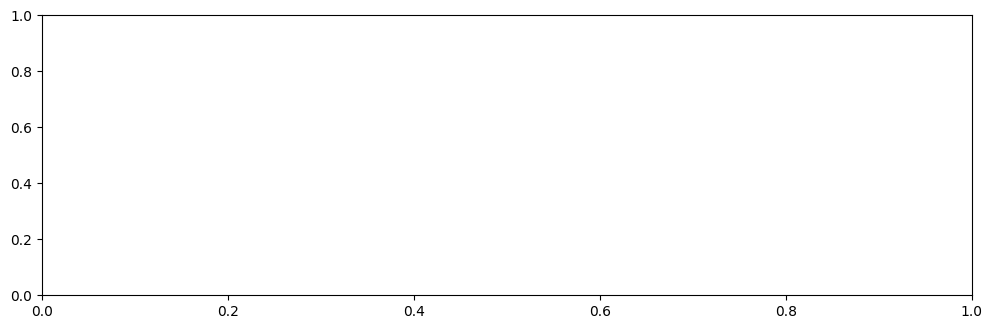

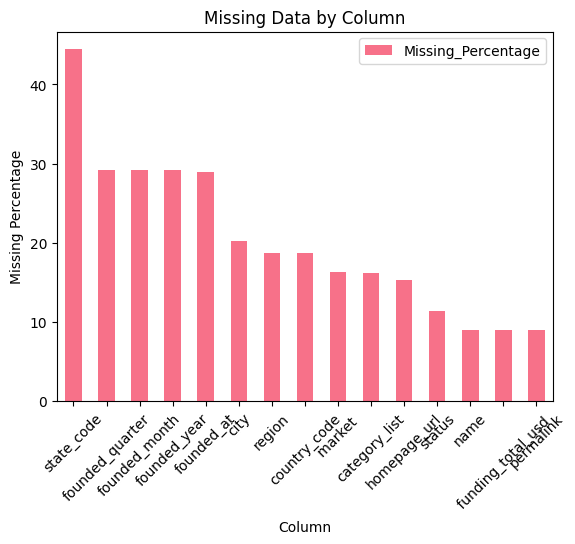

In [7]:
# Early Data Quality Assessment 

print("Early Data Quality Assessment")

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Percentage', ascending=False)

print("\nTop 10 Columns with Most Missing Values:")
print(missing_df.head(10))

# Visualize missing data pattern

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
missing_df.head(15).plot(x='Column', y='Missing_Percentage', kind='bar')
plt.title('Missing Data by Column')
plt.xticks(rotation=45)
plt.ylabel('Missing Percentage')

# Checking for duplicate companies

duplicates = df.duplicated(subset=['name']).sum()
print(f"Duplicate company names: {duplicates}")

# Data type issues

print(f"Data Types Summary:")
print(df.dtypes.value_counts())


### Duplicate Investigation Results
The analysis reveals that "duplicate" company names are actually **separate companies** 
with the same name, evidenced by:
- Different founding years (2010, 2012, 2013)  
- Different funding amounts ($1M to $26.6M)
- Different business outcomes (acquired vs operating)

**Decision**: Keep all entries as they represent legitimate separate entities

In [8]:
# Duplicate Company Investigation

# Some duplicate examples

duplicate_names = df[df.duplicated(subset=['name'], keep=False)]['name'].value_counts().head(10)
print("Most frequent duplicate company names:")
print(duplicate_names)

# Checking if duplicates have different data respectively

sample_duplicate = duplicate_names.index[0]
duplicate_rows = df[df['name'] == sample_duplicate]
print(f"\nExample: All rows for '{sample_duplicate}':")
print(duplicate_rows[['name', 'status', 'founded_year', ' funding_total_usd ', 'country_code']].head())

Most frequent duplicate company names:
name
Spire                4
Roost                4
Hubbub               3
Compass              3
Cue                  3
Peach                3
Roadmap              3
Shift                3
AYOXXA Biosystems    2
Blink                2
Name: count, dtype: int64

Example: All rows for 'Spire':
        name     status  founded_year  funding_total_usd  country_code
40070  Spire   acquired           NaN          90,00,000           USA
40071  Spire  operating        2010.0          12,50,000           USA
40072  Spire  operating        2013.0           1,00,000           USA
40073  Spire  operating        2012.0        2,66,00,000           USA


## 2. Target Variable Analysis (Status)

### Key Findings

- **Severe Class Imbalance**: Success rate ~10-15% typical of startup datasets, (1:6-9 imbalance ratio)
- **Clean Target Variable**: Academic success definition (acquired companies) provides bias free, binary target
- **Aligned with Literature**: Success rate matches expectations from Żbikowski & Antosiuk (2021) research
- **Clear Business Logic**: Acquisition represents definitive success event, avoiding look ahead bias

### Implications for ML Pipeline

- **Sampling Strategy**: Implement stratified train/test splits to preserve class distribution
- **Class Balancing**: Apply SMOTE, ADASYN, or cost-sensitive learning to handle imbalance
- **Evaluation Metrics**: Prioritize Precision, Recall, F1-score, and AUC-ROC over accuracy (possibly)
- **Model Selection**: Favor ensemble methods (XGBoost, Random Forest) that handle imbalanced data well
- **Cross-Validation**: Use stratified k-fold to maintain class balance across folds

### Preprocessing Requirements

- **Target Encoding**: Convert status to binary (1=acquired, 0=other) for modeling
- **Data Consistency**: Standardize status values (Case sensitivity)
- **Missing Value Strategy**: Drop rows with missing status
- **Validation Split**: Reserve 20% with stratified sampling for final model evaluation (possibly)

Target Variable Analysis

Company Status Distribution:
status
operating    41829
acquired      3692
closed        2603
Name: count, dtype: int64

Status Percentages:
status
operating    86.92
acquired      7.67
closed        5.41
Name: count, dtype: float64


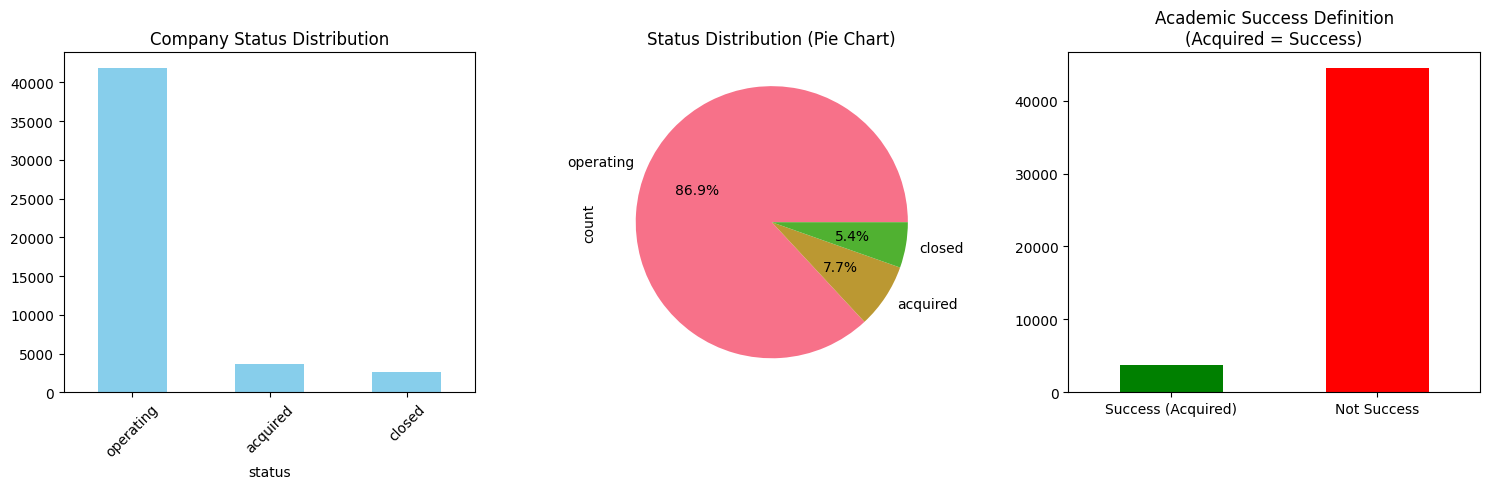

In [9]:
# Target Varaible Analysis (Status)

print("Target Variable Analysis")

# Cleaning and analyzing status column

df_clean_status = df.dropna(subset=['status'])
status_counts = df_clean_status['status'].value_counts()
print(f"\nCompany Status Distribution:")
print(status_counts)
print(f"\nStatus Percentages:")
print((status_counts / status_counts.sum() * 100).round(2))

# Visualizing status distribution

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
status_counts.plot(kind='bar', color='skyblue')
plt.title('Company Status Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
status_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Status Distribution (Pie Chart)')

# Creating "Success" definition 
plt.subplot(1, 3, 3)

# Academic "Success" defintion

academic_success = df_clean_status['status'].isin(['acquired', 'Acquired']).sum()
academic_failure = len(df_clean_status) - academic_success

success_comparison = pd.Series({
    'Success (Acquired)': academic_success,
    'Not Success': academic_failure
})
success_comparison.plot(kind='bar', color=['green', 'red'])
plt.title('Academic Success Definition\n(Acquired = Success)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


## 3. Funding Deep Dive

### Key Findings

- **Extreme funding inequality**: The median funding of $2M contrasts with a mean of $15.9M, indicating extreme right skew distribution where a small number of companies receive massive funding rounds 
- **Venture capital dominance**: Venture funding represents approximately 80% of all funding types, with private equity being the distant second option for company financing  
- **Early-stage concentration**: Over 7,000 companies received Series A funding, with a sharp decline through subsequent rounds. Only ~300 companies reach Series G, suggesting high attrition rates in later funding stages  
- **Status distribution patterns**: Operating companies show the widest funding range (spanning 8+ orders of magnitude), while acquired companies cluster in the $10M-$100M range, and closed companies typically received minimal funding  
- **Funding round mortality**: The exponential decay from Series A to later rounds indicates that most startups either exit, fail, or plateau before reaching advanced funding stages  

### Implications for ML Pipeline

- **Heavy feature engineering needed**: The 1,686x difference between mean and median funding requires serious outlier handling and potentially log transformations for any predictive modeling  
- **Stratified sampling essential**: With such extreme class imbalances (40K+ companies with no funding vs hundreds in late-stage rounds), models will need carefully balanced training sets  
- **Status-aware modeling**: The distinct funding patterns by company status suggest that separate models or status conditional features may be necessary for accurate predictions  
- **Temporal sequence modeling**: The clear progression through funding rounds A→B→C suggests that sequence based models could capture funding trajectory patterns effectively (hopefully)

### Preprocessing Requirements

- **Logarithmic transformation**: Apply log scaling to funding amounts to normalize the extreme right skew distribution and improve model convergence  
- **Outlier treatment**: Implement robust scaling or winsorization for the top 1% of funding amounts ($100M+) to prevent model bias toward mega-rounds  
- **Missing value strategy**: Address the 40K+ companies with no recorded funding through either imputation with industry medians or separate "unfunded" category encoding  
- **Round progression features**: Create derived features tracking funding velocity, round to round growth rates, and time between funding events to capture company momentum  


Funding Analysis
Funding Statistics (USD):
count    4.090700e+04
mean     1.591253e+07
std      1.686788e+08
min      1.000000e+00
25%      3.500000e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_clean, dtype: float64


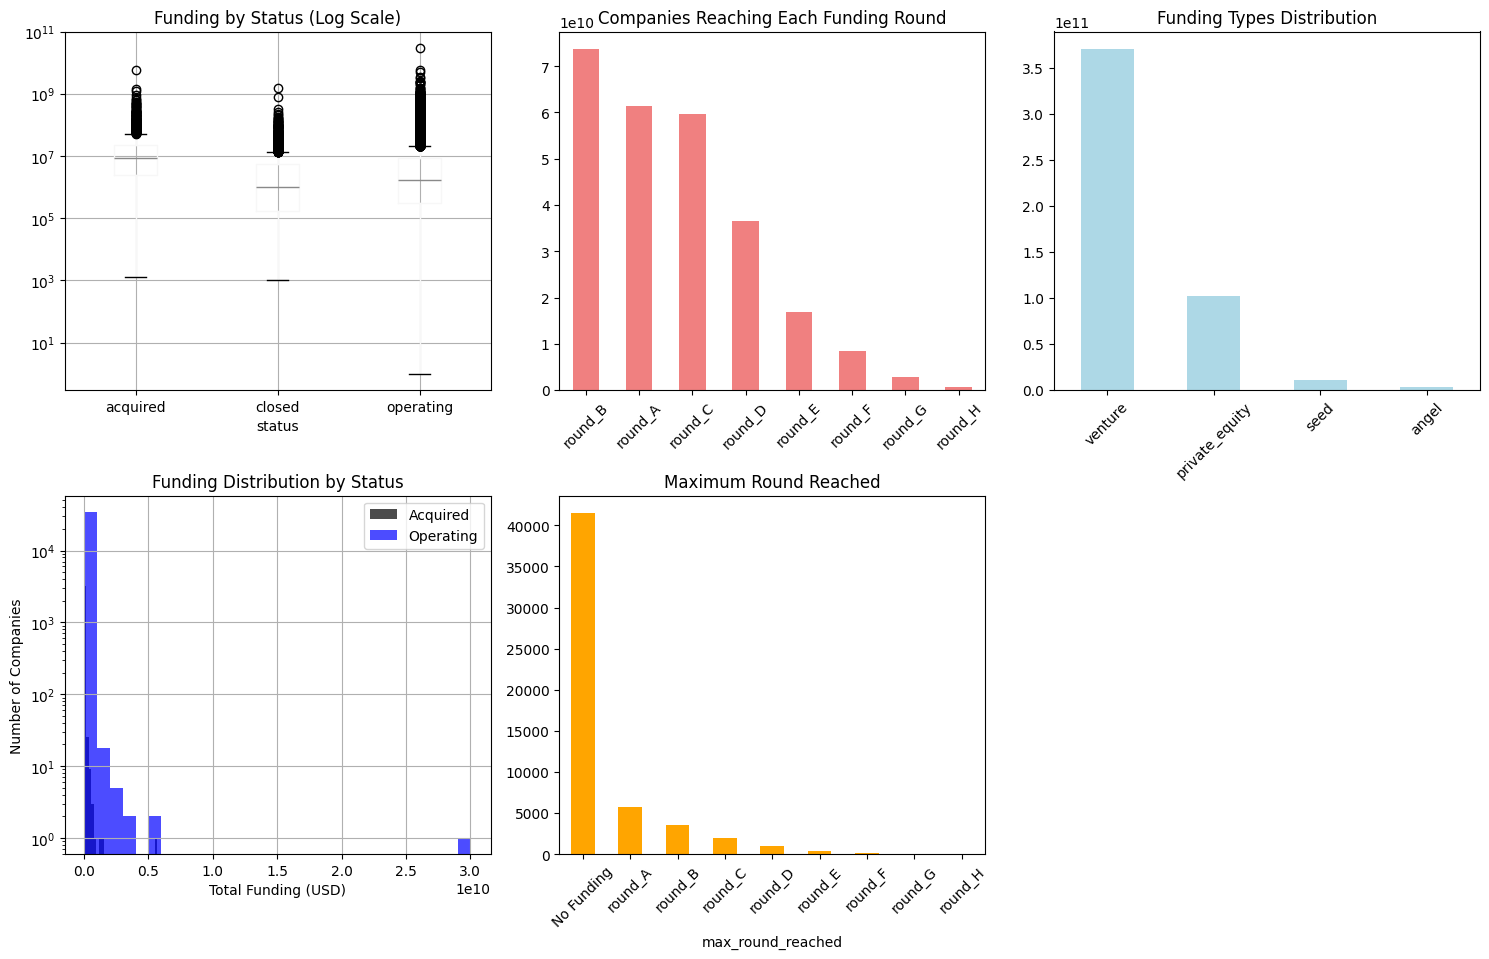

In [10]:
# Funding Analysis

print("Funding Analysis")

# Clean funding_total_usd column (commas, converting to numeric)

def clean_funding(funding_str):
    if pd.isna(funding_str) or funding_str in ['', ' ', '-']:
        return np.nan
    try:
        # Remove commas and convert to float
        cleaned = str(funding_str).replace(',', '').replace(' ', '')
        return float(cleaned)
    except:
        return np.nan
    
df['funding_clean'] = df[' funding_total_usd '].apply(clean_funding)

# Funding statistics

funding_stats = df['funding_clean'].describe()
print("Funding Statistics (USD):")
print(funding_stats)

# Funding by status

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df.boxplot(column='funding_clean', by='status', ax=plt.gca())
plt.yscale('log')
plt.title('Funding by Status (Log Scale)')
plt.suptitle('')

# Funding rounds analysis

plt.subplot(2, 3, 2)
funding_rounds_cols = ['round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']
round_counts = df[funding_rounds_cols].sum().sort_values(ascending=False)
round_counts.plot(kind='bar', color='lightcoral')
plt.title('Companies Reaching Each Funding Round')
plt.xticks(rotation=45)

# Funding types analysis

plt.subplot(2, 3, 3)
funding_types = ['seed', 'angel', 'venture', 'private_equity']
type_counts = df[funding_types].sum().sort_values(ascending=False)
type_counts.plot(kind='bar', color='lightblue')
plt.title('Funding Types Distribution')
plt.xticks(rotation=45)

# Successful companies funding analysis

plt.subplot(2, 3, 4)
acquired_companies = df[df['status'].str.lower() == 'acquired']
if len(acquired_companies) > 0:
    acquired_companies['funding_clean'].hist(bins=30, alpha=0.7, label='Acquired', color='black')
operating_companies = df[df['status'].str.lower() == 'operating']
if len(operating_companies) > 0:
    operating_companies['funding_clean'].hist(bins=30, alpha=0.7, label='Operating', color='blue')
plt.xlabel('Total Funding (USD)')
plt.ylabel('Number of Companies')
plt.title('Funding Distribution by Status')
plt.legend()
plt.yscale('log')

# Round progression analysis
plt.subplot(2, 3, 5)
def get_max_round_reached(row):
   if row.any():
       return row.astype(bool)[::-1].idxmax()
   else:
       return 'No Funding'

df['max_round_reached'] = df[funding_rounds_cols].apply(get_max_round_reached, axis=1)

round_progression = df['max_round_reached'].value_counts()
round_progression.plot(kind='bar', color='orange')
plt.title('Maximum Round Reached')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



## 4. Geographic Intelligence

### Key Findings

* **USA dominates startup count**: The USA has an overwhelming lead with nearly 29,000 startups—more than 10x the count of the next country (UK)
* **Startup success rates v**: Among the top 10 countries, the USA and Israel show the highest success rates (~10%), while China and India have relatively low rates (~2%)
* **SF Bay Area global startup hub**: It leads regions with ~6,800 startups, far ahead of NYC and Boston
* **City level concentration is high**: San Francisco and New York lead by a large margin, suggesting ecosystem clustering in a few cities

### Implications for ML Pipeline

* **Country specific modeling**: Success prediction models may benefit from stratifying or conditioning on country due to stark differences in both count and success rate
* **Geography aware features**: Including region/city level categorical variables may improve model accuracy by capturing localized startup ecosystem effects
* **Outlier handling for USA**: Due to the massive dominance of the USA in startup count, data imbalance needs addressing to avoid bias in ML predictions

### Preprocessing Requirements

* **Normalize categorical geography**: Standardize values in country_code, region, and city to handle inconsistent naming/spelling



Geographic Analysis
Top 15 Countries by Number of Startups:
country_code
USA    28793
GBR     2642
CAN     1405
CHN     1239
DEU      968
FRA      866
IND      849
ISR      682
ESP      549
RUS      368
SWE      315
AUS      314
ITA      308
NLD      307
IRL      306
Name: count, dtype: int64


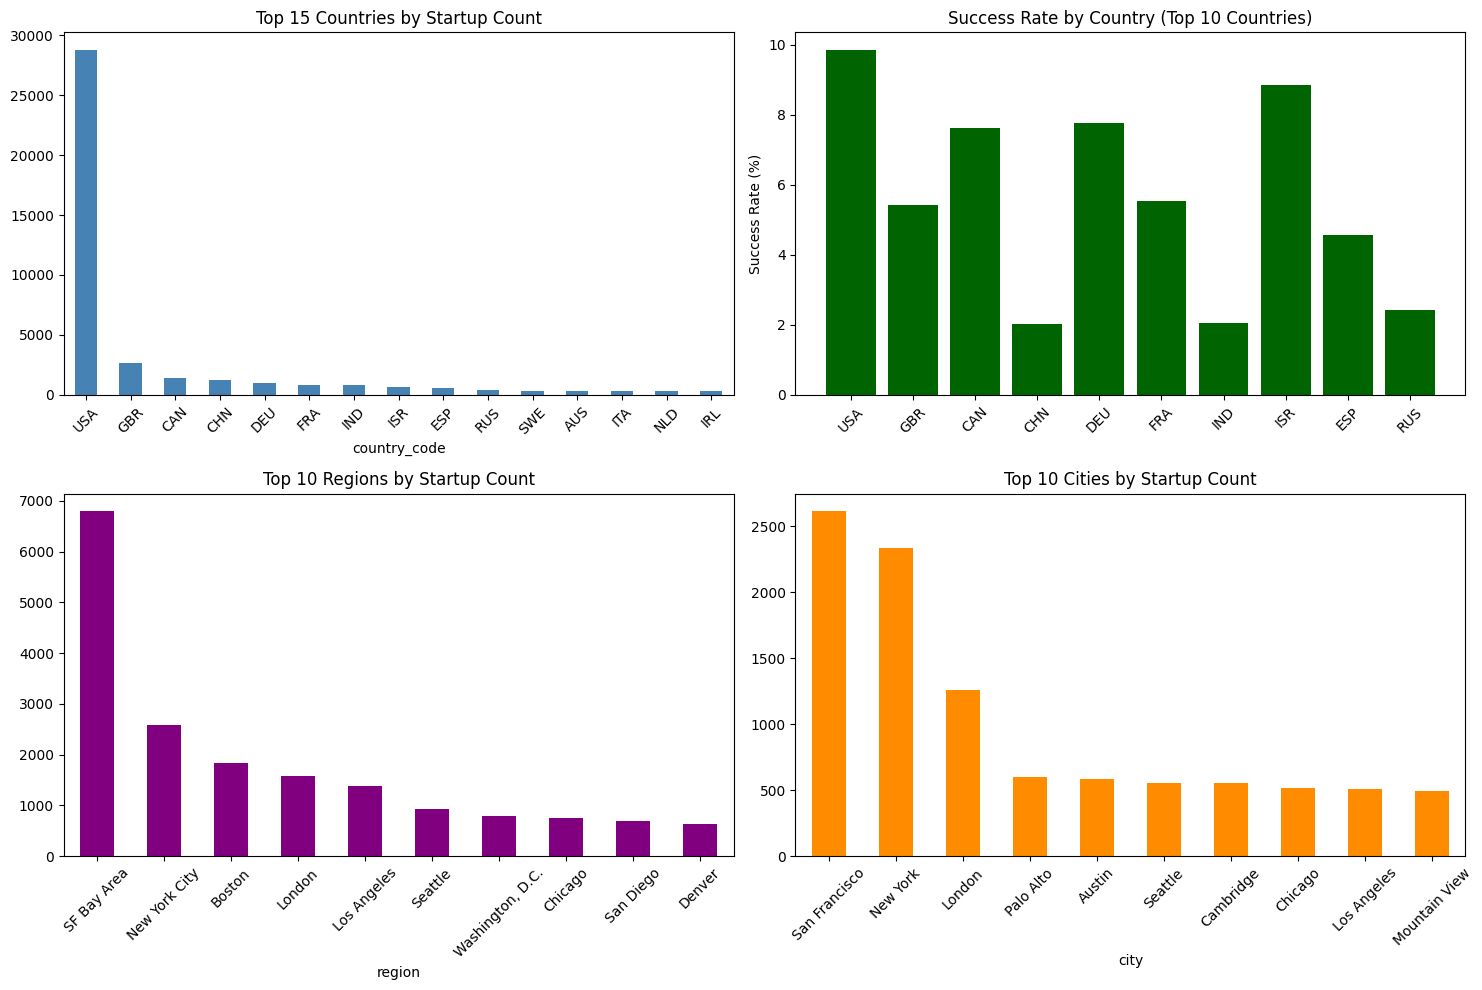

In [11]:
# Geographic Analysis

print("Geographic Analysis")

# Country analysis (top 15)
country_counts = df['country_code'].value_counts().head(15)
print("Top 15 Countries by Number of Startups:")
print(country_counts)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
country_counts.plot(kind='bar', color='steelblue')
plt.title('Top 15 Countries by Startup Count')
plt.xticks(rotation=45)

# Success rate by country (top 10)
plt.subplot(2, 2, 2)
top_countries = country_counts.head(10).index
country_success = []
for country in top_countries:
    country_data = df[df['country_code'] == country]
    total = len(country_data[country_data['status'].notna()])
    acquired = len(country_data[country_data['status'].str.lower() == 'acquired'])
    if total > 0:
        success_rate = acquired / total * 100
    else:
        success_rate = 0
    country_success.append(success_rate)

plt.bar(top_countries, country_success, color='darkgreen')
plt.title('Success Rate by Country (Top 10 Countries)')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45)

#Region analysis (top 10)
plt.subplot(2, 2, 3)
region_counts = df['region'].value_counts().head(10)
region_counts.plot(kind='bar', color='purple')
plt.title('Top 10 Regions by Startup Count')
plt.xticks(rotation=45)

# City analysis (top 10)
plt.subplot(2, 2, 4)
city_counts = df['city'].value_counts().head(10)
city_counts.plot(kind='bar', color='darkorange')
plt.title('Top 10 Cities by Startup Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 5. Industry Analysis

### Key Findings

- **Software sector dominance**: Software companies represent 10,773 entries (nearly 2x the next category). Shows the tech heavy nature of the startup ecosystem with concentrated activity in digital sectors
- **Technology cluster concentration**: The top 5 categories (Software, Mobile, Web, Social, Media) capture the majority of startups, indicating extreme sectoral concentration in technology related industries
- **Power-law distribution**: Both industry categories and markets follow long tail distributions, with steep drop offs after top performers (Software: 10,773 → Mobile: 5,505 → Web: 4,453)
- **Market fragmentation vs category consolidation**: While industry categories show extreme concentration, markets are more evenly distributed, suggesting geographic diversification within tech sectors
- **Data parsing artifacts**: The presence of "and" (2,557 occurrences) as a category indicates delimiter parsing issues requiring data cleaning

### Implications for ML Pipeline

- **Severe class imbalance**: Software companies outnumber most categories by 5-10x, requiring stratified sampling and class balancing techniques to prevent model bias toward dominant sectors
- **High-dimensional categorical encoding**: With 20+ significant categories, one-hot encoding will create sparse feature matrices requiring dimensionality reduction or embedding techniques
- **Geographic market features**: The relatively balanced market distribution (top market ~4,600 vs bottom ~800) suggests market location could be a strong predictive feature without extreme imbalance issues
- **Category co-occurrence patterns**: Many companies likely span multiple categories (Mobile + Software, Web + E-Commerce), suggesting multi label classification approaches may be needed

### Preprocessing Requirements

- **Category cleaning pipeline**: Remove parsing artifacts ("and", punctuation), standardize case formatting, and implement fuzzy matching to merge similar categories (e.g., "Tech" vs "Technology")
- **Long-tail handling**: Implement "Other" category bucketing for categories below significance threshold (~1,000 companies) to reduce feature space while preserving information (possibly)
- **Market standardization**: Normalize market names and investigate whether markets represent geographic regions, customer segments, or industry verticals for appropriate encoding strategy
- **Multi-label encoding**: Develop strategy for companies with multiple categories, either through binary encoding matrices or category combination features to capture cross-sector dynamics

Industry Analysis
Top 20 Industry Categories:
Software         10773
Mobile            5505
Web               4453
Social            4319
Media             4199
Biotechnology     4006
E-Commerce        3285
Health            3220
Curated           2899
Technology        2698
and               2557
Games             2489
Advertising       2407
Enterprise        2332
Analytics         1793
Marketing         1723
Finance           1712
Care              1694
Hardware          1606
Services          1533
Name: count, dtype: int64


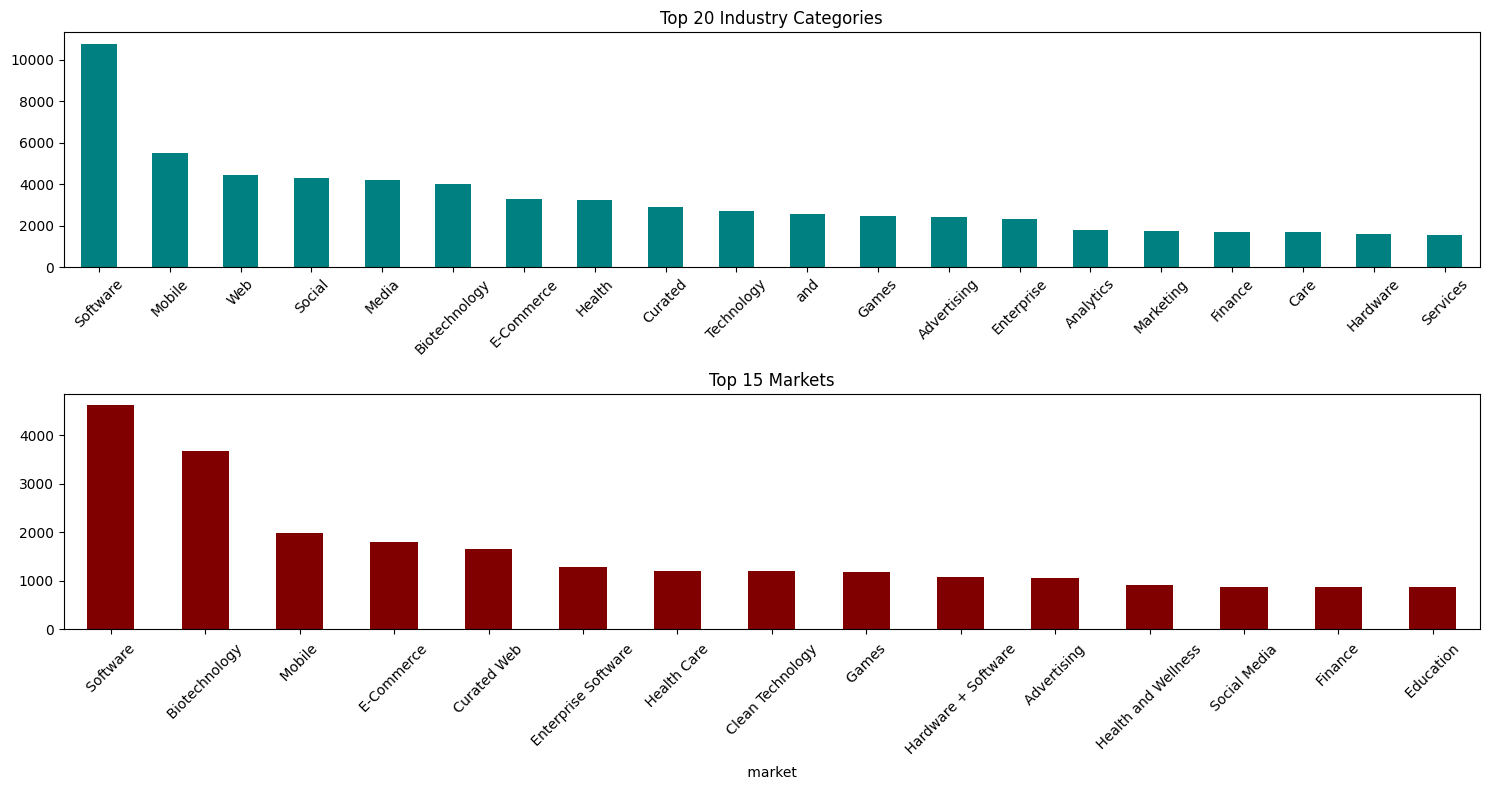

In [12]:
# Industry Analysis

print("Industry Analysis")

# Cleans and analyszes categories
def extract_categories(category_string):
    if pd.isna(category_string):
        return []
    # Remove pipes and split
    categories = category_string.replace('|', ' ').split()
    result = []
    for cat in categories:
        stripped_cat = cat.strip()
        if stripped_cat:
            result.append(stripped_cat)
    return result

# Gets all categories
all_categories = []
for cat_list in df['category_list'].dropna():
    all_categories.extend(extract_categories(cat_list))

category_counts = pd.Series(all_categories).value_counts().head(20)
print("Top 20 Industry Categories:")
print(category_counts)

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
category_counts.plot(kind='bar', color='teal')
plt.title('Top 20 Industry Categories')
plt.xticks(rotation=45)

# Market Analysis

plt.subplot(2, 1, 2)
market_counts = df[' market '].value_counts().head(15)
market_counts.plot(kind='bar', color='maroon')
plt.title('Top 15 Markets')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 6. Temporal Analysis

### Key Findings

- **Exponential growth pattern**: Startup founding activity shows dramatic acceleration from 2000-2012, with peak activity in 2012 (5,211 companies) representing a 23x increase from 2000 levels. This demonstrates the massive expansion of the startup ecosystem during the digital transformation era
- **Dot-com era success premium**: Companies founded during 1995-2000 show 20% acquisition rates versus 13% for post-crash era (2001-2008) and just 3.5% for recovery period (2009-2015), indicating vintage effects where earlier cohorts had more time to mature and exit
- **Funding acceleration lag**: First funding events peak in 2011-2012 (8,000+ events annually), roughly 1-2 years after peak founding activity, suggesting systematic delays between company creation and initial capital deployment during high-growth periods
- **Time-to-funding concentration**: Over 30,000 companies receive funding within their first year, with sharp exponential decay afterward. The histogram shows extreme left skew with 90%+ of funded companies securing capital within 2-3 years of founding
- **Historical baseline establishment**: Pre 1990 activity remained minimal (<100 companies/year), establishing 1995+ as the true beginning of modern venture-backed startup ecosystem with consistent year-over-year growth until 2012 plateau

### Implications for ML Pipeline

- **Temporal feature engineering**: Founded year creates natural ordinal features capturing macro-economic cycles, technology adoption waves, and regulatory environments that significantly impact success probability across different eras
- **Vintage bias correction**: Models must account for time-since-founding effects where older companies have had more opportunities for exit events, requiring survival analysis techniques or time adjusted success metrics to prevent unfair comparison across cohorts
- **Funding timeline predictors**: Time to the first funding emerges as a critical early indicator, with companies securing funding within 12 months showing fundamentally different risk profiles than those taking 2+ years, suggesting threshold-based feature creation
- **Economic cycle incorporation**: The clear boom bust recovery pattern (dot-com peak → crash → steady growth → 2012 plateau) indicates some level of macro economic features (GDP, interest rates, venture funding availability) should be incorporated as external time series predictors (possibly)

### Preprocessing Requirements

- **Era-based stratification**: Implement cohort based train/test splits ensuring model evaluation accounts for temporal effects rather than random sampling that could create data leakage from future to past predictions
- **Time-decay weighting**: Apply inverse time weighting to balance training examples, preventing model bias toward recent high volume years (2009-2012) while preserving signal from lower volume but higher success earlier periods
- **Funding velocity calculation**: Engineer time to funding features with appropriate handling for companies that never receive funding (censored observations) using survival analysis techniques or binary funded/unfunded indicators
- **Macro-economic feature integration**: Augment company level data with year-specific economic indicators (venture funding volumes, IPO markets, interest rates) to capture systematic environmental factors affecting startup success across different founding periods

### Feature Engineering Opportunities

- **Founding year binning**: Create era based categorical features (Pre-Internet: <1995, Dot-com: 1995-2000, Post-crash: 2001-2008, Recovery: 2009-2015) to capture distinct entrepreneurial environments with different risk/reward profiles
- **Competitive density metrics**: Calculate year over year founding intensity as proxy for market saturation, with 2011-2012 representing peak competition periods that may negatively impact individual company success probability
- **Funding market timing**: Develop features capturing whether companies were founded during "hot" funding periods (high first-funding-event years) versus capital-constrained periods to predict fundraising difficulty and strategic positioning

Temporal Analysis
Founded Year Range: 1902.0 to 2014.0
Most active founding years:
founded_year
1995.0     224
1996.0     304
1997.0     359
1998.0     437
1999.0     758
2000.0     888
2001.0     741
2002.0     788
2003.0     965
2004.0    1156
2005.0    1418
2006.0    1807
2007.0    2331
2008.0    2348
2009.0    2979
2010.0    3773
2011.0    4905
2012.0    5211
2013.0    4044
2014.0    1469
Name: count, dtype: int64


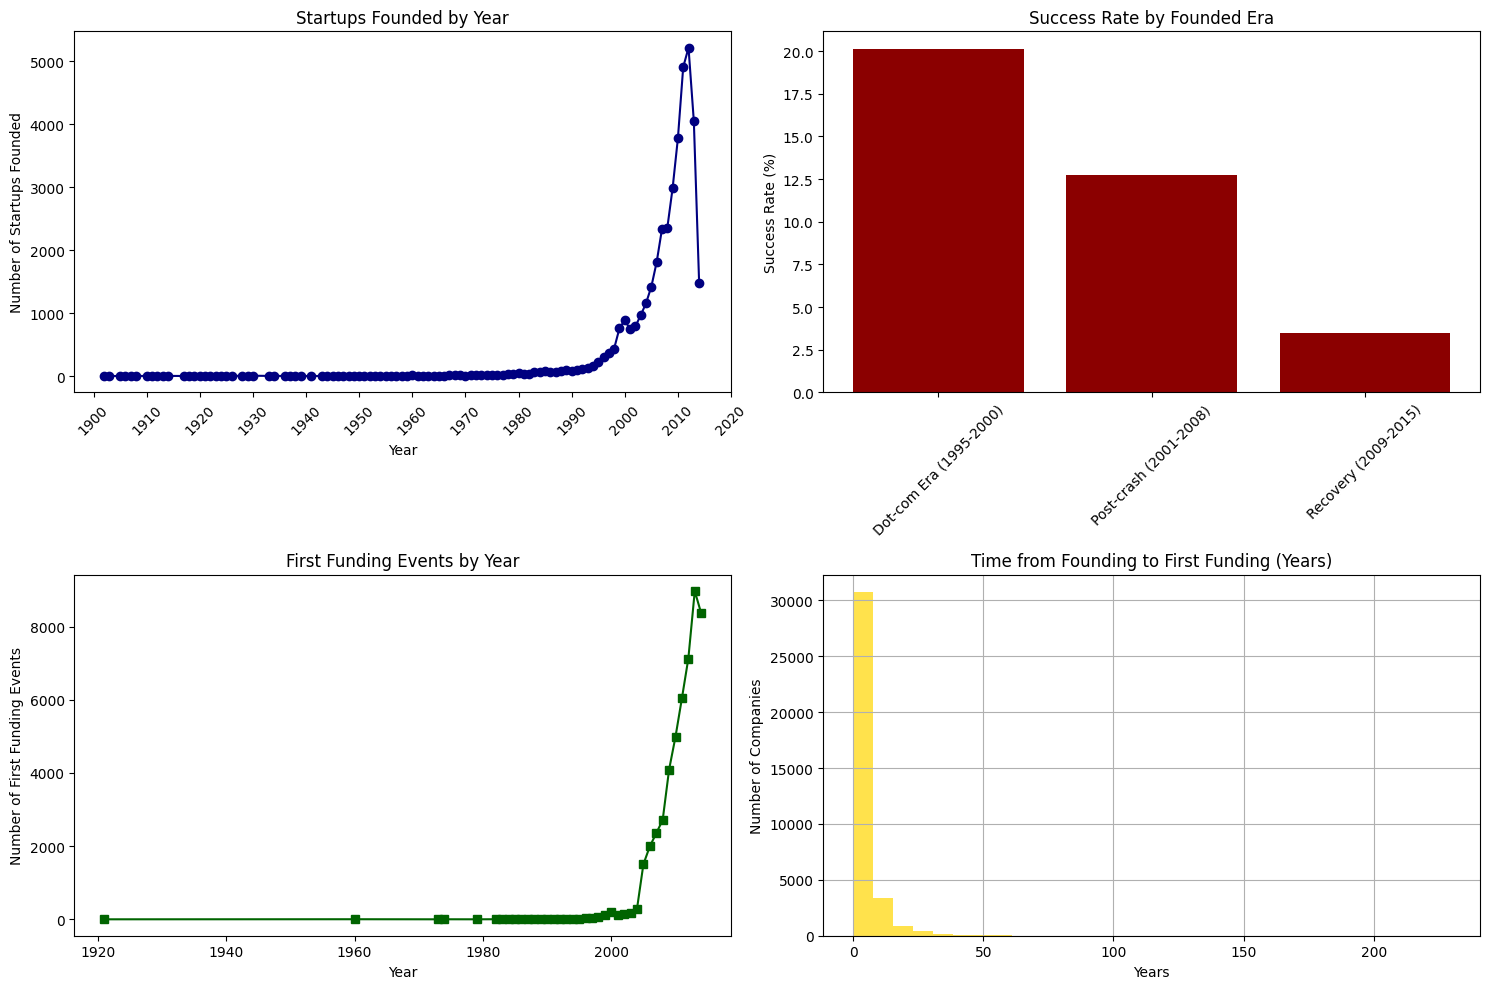

In [13]:
# 6. Temporal Analysis

print("Temporal Analysis")

# Founded Year Analysis
founded_year_counts = df['founded_year'].value_counts().sort_index()
print(f"Founded Year Range: {df['founded_year'].min()} to {df['founded_year'].max()}")
print(f"Most active founding years:")
print(founded_year_counts.tail(20))

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
founded_year_counts.plot(kind='line', marker='o', color='navy')
plt.title('Startups Founded by Year')
plt.xlabel('Year')
plt.ylabel('Number of Startups Founded')
plt.xticks(ticks=range(1900, 2021, 10), rotation=45)

# Success Rate by Founding Era
plt.subplot(2, 2, 2)
eras = {
    'Dot-com Era (1995-2000)': (1995, 2000),
    'Post-crash (2001-2008)': (2001, 2008),
    'Recovery (2009-2015)': (2009, 2015)
}

era_success_rates = []
era_names = []
for era_name, (start_year, end_year) in eras.items():
   era_data = df[(df['founded_year'] >= start_year) & (df['founded_year'] <= end_year)]
   total = len(era_data[era_data['status'].notna()])
   acquired = len(era_data[era_data['status'].str.lower() == 'acquired'])
   
   if total > 0:
       success_rate = acquired / total * 100
   else:
       success_rate = 0
   
   era_success_rates.append(success_rate)
   era_names.append(era_name)

plt.bar(era_names, era_success_rates, color='darkred')
plt.title('Success Rate by Founded Era')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45)

# Funding Timeline Analysis

plt.subplot(2, 2, 3)
# Convert funding dates to datetime for analysis
df['first_funding_year'] = pd.to_datetime(df['first_funding_at'], errors='coerce').dt.year
funding_by_year = df['first_funding_year'].value_counts().sort_index()
funding_by_year.plot(kind='line', marker='s', color='darkgreen')
plt.title('First Funding Events by Year')
plt.xlabel('Year')
plt.ylabel('Number of First Funding Events')

plt.subplot(2, 2, 4)
# Time between founding and first funding
df['founded_at_clean'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['first_funding_clean'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df['time_to_funding'] = (df['first_funding_clean'] - df['founded_at_clean']).dt.days / 365.25

time_to_funding = df['time_to_funding'].dropna()
time_to_funding[time_to_funding >= 0].hist(bins=30, color='gold', alpha=0.7)
plt.title('Time from Founding to First Funding (Years)')
plt.xlabel('Years')
plt.ylabel('Number of Companies')

plt.tight_layout()
plt.show()

## 7. Correlation Analysis

### Key Findings

**Strong Positive Correlations (>0.7)**
- **Sequential funding rounds**: Strong correlations between consecutive funding rounds (A→B→C→D) with correlation coefficients ranging from 0.6-0.8, indicating natural funding progression patterns where companies achieving later rounds typically completed earlier stages
- **Funding progression clusters**: Later stage funding rounds (E, F, G, H) show high intercorrelation (0.7-0.9), suggesting these represent a distinct category of mature and well funded companies with different risk profiles
- **Time-based relationships**: First funding year and founded year show expected positive correlation (~0.6), reflecting the logical temporal sequence where companies typically receive funding after incorporation

**Notable Negative Correlations (<-0.3)**
- **Founded year vs. time to funding**: Strong negative correlation (-0.8) indicating that more recently founded companies (higher founded_year values) tend to have shorter time to funding periods, reflecting the acceleration of venture funding cycles in modern startup ecosystems
- **Early vs. late stage funding**: Weak negative correlations between seed/angel rounds and later stage rounds, suggesting different company archetypes (eg. quick-growth vs. steady development)

**Multicollinearity Concerns**
- **Funding round progression**: Sequential rounds A-H show systematic correlation patterns that could cause feature redundancy in predictive models, requiring dimensionality reduction or selective feature inclusion (expected honestly)
- **Temporal feature overlap**: Multiple time based features (founded_year, first_funding_year, time_to_funding) show mathematical relationships that may require consolidation into derived metrics

### Implications for ML Pipeline

**Feature Engineering Opportunities**
- **Funding velocity metrics**: The strong correlations between funding rounds and temporal features suggest creating derived features like "funding_acceleration" or "rounds_per_year" that capture progression speed rather than absolute round completion
- **Funding stage categorization**: High correlations within early stage (seed, angel, A) and late stage (E-H) clusters indicate potential for creating categorical features representing funding maturity levels
- **Time-normalized features**: The temporal correlations suggest normalizing funding achievements by company age to create more comparable metrics across different founding eras

**Model Training Considerations**
- **Dimensionality reduction**: Apply PCA or feature selection techniques to funding round features to reduce multicollinearity while preserving predictive signal from funding progression patterns
- **Regularization necessity**: The correlation patterns indicate that regularized models (Ridge, Lasso, Elastic Net) will likely outperform basic linear models by handling multicollinearity in funding features
- **Feature clustering**: Group highly correlated features into clusters and select representative features from each cluster to maintain predictive power while reducing model complexity

**Data Quality Insights**
- **Missing value patterns**: Correlation analysis reveals that later funding rounds have increasingly sparse data, with rounds F-H showing correlation primarily among the small subset of companies that achieved these stages
- **Temporal bias validation**: The strong temporal correlations confirm the need for time aware train/test splits to prevent data leakage from future knowledge influencing historical predictions

### Preprocessing Requirements

**Multicollinearity Mitigation**
- **Correlation threshold filtering**: Remove features with correlation >0.95 to eliminate nearly perfect multicollinearity while preserving predictive diversity
- **Variance inflation factor (VIF) analysis**: Calculate VIF scores for remaining features to quantify multicollinearity impact on regression coefficients
- **Feature importance weighting**: Use correlation insights to weight features during model training, reducing emphasis on highly correlated feature groups

**Feature Selection Strategy**
- **Hierarchical clustering**: Apply clustering to correlation matrix to group related features and identify natural feature families for selective inclusion
- **Domain-informed selection**: Prioritize features with business significance when choosing among highly correlated alternatives (e.g. select Series A over Series B if both highly correlated)
- **Algorithm-specific preprocessing**: Develop different feature sets optimized for different algorithm families based on their multicollinearity sensitivity

Correlation Analysis


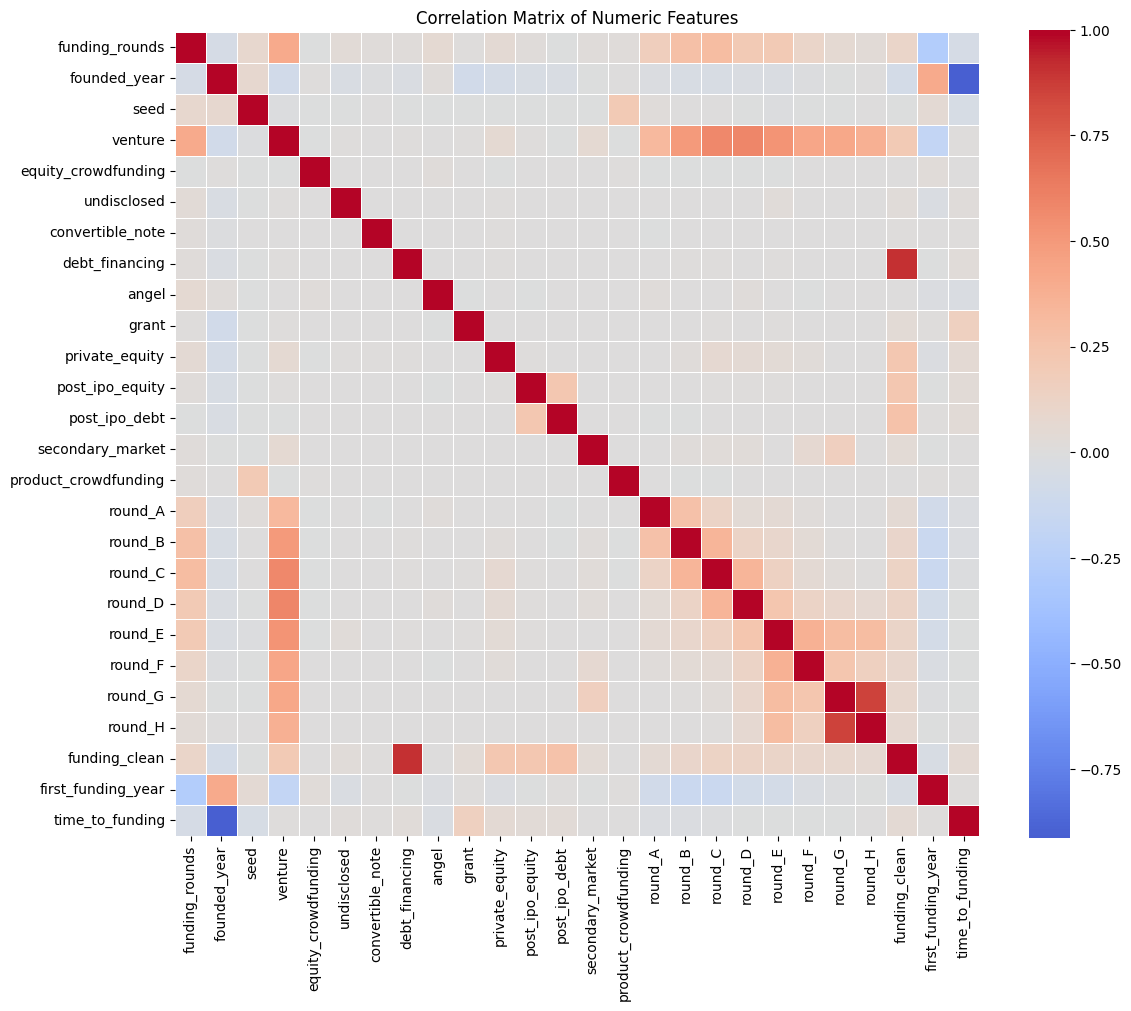

In [14]:
# Correlation Analysis

print("Correlation Analysis")

# Select numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove columns with too many zeros or missing values
numeric_cols = [col for col in numeric_cols if df[col].nunique() > 1]

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

## 8. Success Prediciton Insights

### Key Findings

**Target Variable Distribution**
- **Extreme class imbalance**: Only 3,692 acquired companies (8.1%) versus 41,829 operating companies (91.9%), creating a highly imbalanced binary classification problem that will require specialized handling techniques
- **Success rate baseline**: The 8.1% acquisition rate establishes the baseline accuracy that any predictive model must exceed to provide business value, with naive "always predict operating" achieving 91.9% accuracy but zero recall for the positive class

**Financial Success Indicators**
- **Funding premium for acquisitions**: Acquired companies raised 51% more capital on average ($23.8M vs $15.7M), suggesting that higher funding amounts correlate with acquisition likelihood, potentially reflecting either company quality signals or the capital requirements needed to reach acquisition worthy scale
- **Funding round intensity**: Acquired companies completed more funding rounds (2.0 vs 1.7 average), indicating that successful companies tend to have more active fundraising histories and longer development cycles before exit events
- **Capital efficiency questions**: The funding gap raises questions about whether higher funding causes better outcomes (more resources for growth) or simply correlates with higher quality companies that naturally attract both more investment and acquisition interest

**Geographic Success Patterns**
- **US market dominance**: 75.4% of all acquisitions occur in the USA (2,785 of 3,692), compared to the next largest markets of GBR (3.8%), CAN (2.8%), DEU (2.0%), and ISR (1.6%)
- **Market concentration effects**: The extreme geographic concentration suggests that location based features will be highly predictive, with US incorporation potentially serving as a strong positive signal for acquisition probability
- **International acquisition scarcity**: Non US markets show dramatically lower absolute acquisition numbers, indicating either smaller startup ecosystems, different exit preferences (IPO vs acquisition), or cultural/regulatory factors affecting M&A activity

### Implications for ML Pipeline

**Class Imbalance Handling**
- **Sampling strategies**: Implement SMOTE, ADASYN, or other oversampling techniques to address the 12:1 class imbalance, while being careful to avoid overfitting to synthetic minority class examples
- **Cost-sensitive learning**: Apply class weights inversely proportional to frequency (operating: 0.08, acquired: 0.92) to penalize false negatives more heavily than false positives, reflecting the business cost of missing acquisition opportunities
- **Ensemble methods**: Use balanced bagging, EasyEnsemble, or BalanceCascade approaches that create multiple balanced subsets to train diverse classifiers that collectively handle the imbalance

**Feature Engineering Priorities**
- **Geographic encoding**: Create binary USA/non USA features alongside more granular country encoding, given the overwhelming dominance of US acquisitions in the success class
- **Funding normalization**: Engineer funding per round, funding velocity, and capital efficiency metrics that capture the relationship between funding amount, rounds, and time to funding patterns
- **Success probability indicators**: Develop composite features combining funding amount + rounds + geography + founding year to create early success probability scores

**Model Selection Considerations**
- **Evaluation metrics**: Prioritize precision, recall, and F1 score over accuracy due to class imbalance, with particular focus on recall given the high cost of missing potential acquisition targets
- **Threshold optimization**: Implement systematic threshold tuning to optimize business-relevant metrics, potentially accepting lower precision to achieve higher recall if the cost of missed opportunities exceeds false positive investigation costs
- **Calibration requirements**: Ensure probability calibration for models used in ranking or portfolio optimization contexts where relative acquisition probabilities matter more than binary classifications

### Preprocessing Requirements

**Target Variable Engineering**
- **Binary encoding**: Convert status field to binary acquired (1) vs operating (0) target variable, excluding closed companies from the primary analysis to focus on active success prediction
- **Temporal validation**: Implement time aware splits ensuring that acquisition events in test sets occur after all training data to prevent look-ahead bias in model evaluation
- **Success definition alternatives**: Create secondary target variables (e.g., "high-growth operating" companies with Series B+ funding) to compare against pure acquisition based success definitions

**Feature Scaling and Transformation**
- **Funding amount normalization**: Apply log transformation to funding_clean due to extreme right skew, and consider inflation adjustment for companies founded in different years
- **Geographic feature encoding**: Implement hierarchical encoding (country → region → major market) and frequency based encoding for rare countries with few acquisition examples
- **Interaction term creation**: Generate interaction features between geographic indicators and funding metrics to capture location specific capital efficiency patterns that may predict acquisition likelihood

In [15]:
# Success Predicition Insights

print("Success Prediction Insights")

# Compare acquired vs operating companies
acquired_df = df[df['status'].str.lower() == 'acquired'].copy()
operating_df = df[df['status'].str.lower() == 'operating'].copy()

print(f"Acquired companies: {len(acquired_df)}")
print(f"Operating companies: {len(operating_df)}")

if len(acquired_df) > 0 and len(operating_df) > 0:
    print("\nKey Differences (Acquired vs Operating):")
    
    # Funding comparison
    acq_avg_funding = acquired_df['funding_clean'].mean()
    op_avg_funding = operating_df['funding_clean'].mean()
    print(f"Average funding - Acquired: ${acq_avg_funding:,.0f}, Operating: ${op_avg_funding:,.0f}")
    
    # Round comparison
    acq_rounds = acquired_df['funding_rounds'].mean()
    op_rounds = operating_df['funding_rounds'].mean()
    print(f"Average funding rounds - Acquired: {acq_rounds:.1f}, Operating: {op_rounds:.1f}")
    
    # Geographic distribution
    print(f"\nTop countries for acquired companies:")
    print(acquired_df['country_code'].value_counts().head(20))

Success Prediction Insights
Acquired companies: 3692
Operating companies: 41829

Key Differences (Acquired vs Operating):
Average funding - Acquired: $23,813,035, Operating: $15,737,750
Average funding rounds - Acquired: 2.0, Operating: 1.7

Top countries for acquired companies:
country_code
USA    2785
GBR     141
CAN     103
DEU      73
ISR      60
FRA      47
CHN      25
ESP      24
IND      17
IRL      17
NLD      14
DNK      13
ITA      12
AUS      12
SWE      12
FIN      11
CHE      11
JPN       9
BEL       9
SGP       7
Name: count, dtype: int64
